## Exploration

train.csv shape is  (139753, 9)
test.csv shape is  (13976, 2)

Missing values in training set:
 Id                            0
ProductId                     0
UserId                        0
HelpfulnessNumerator          0
HelpfulnessDenominator        0
Time                          0
Summary                       1
Text                          1
Score                     13976
dtype: int64

Training set head:
        Id   ProductId          UserId  HelpfulnessNumerator  \
0  1049849  B000MR9D5E  A1EKSETIBS9ETQ                     0   
1   999834  B000GAKFIG   AR0HFYHYHDGQQ                     2   
2   218826  6300215776  A37S3ACL57LN62                    11   
3   796384  B00019071C  A1TO1P3NV7OAU6                     2   
4  1219784  B001NFNFN0   ATCM1W7HWIC6U                     0   

   HelpfulnessDenominator        Time  \
0                       0  1198281600   
1                       5  1245024000   
2                      15  1126137600   
3                       2  1351036

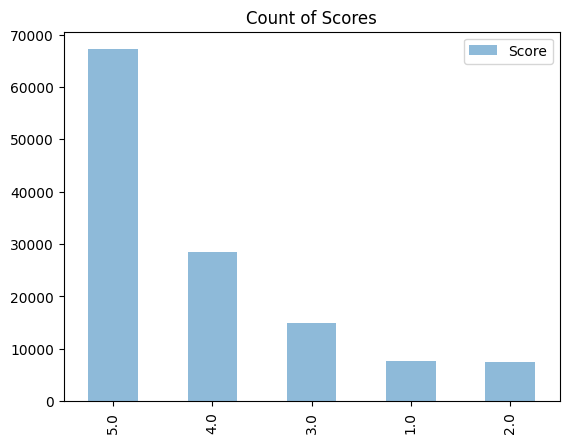

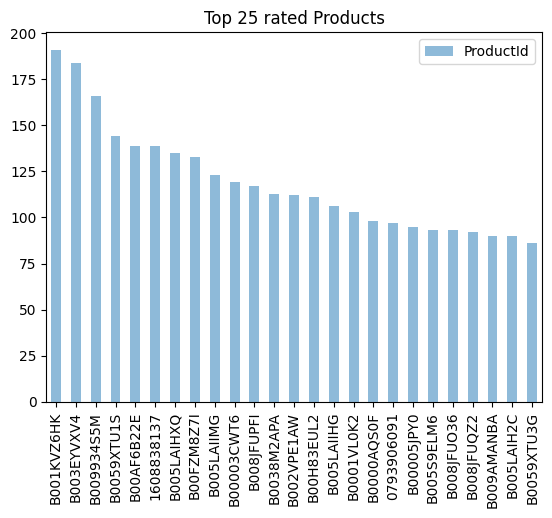

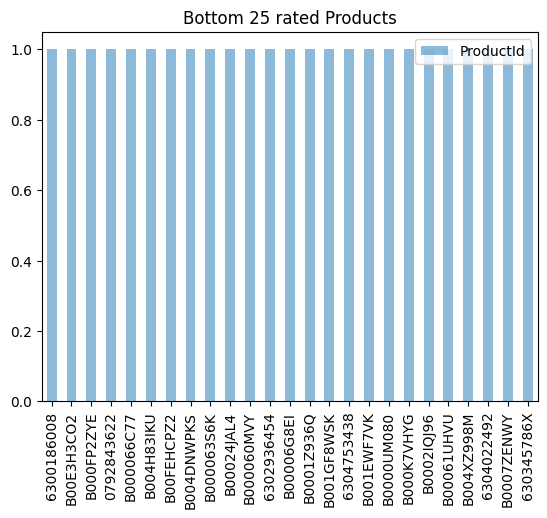

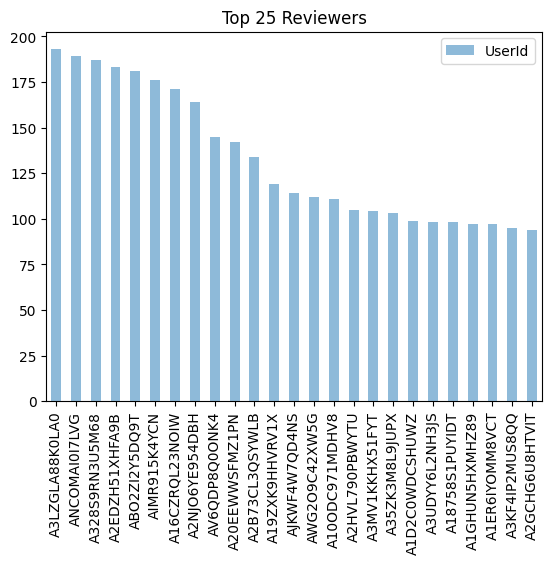

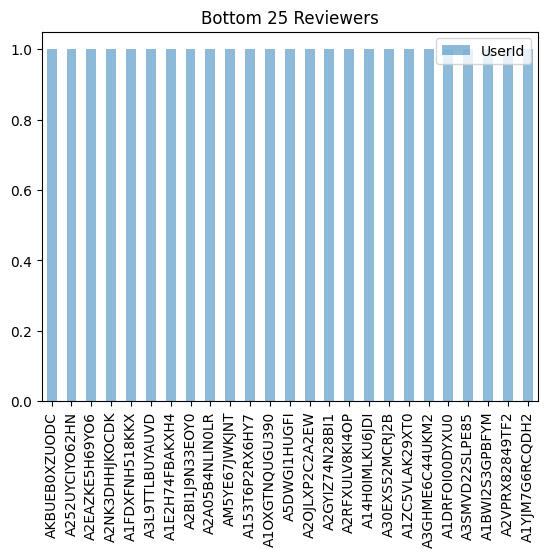

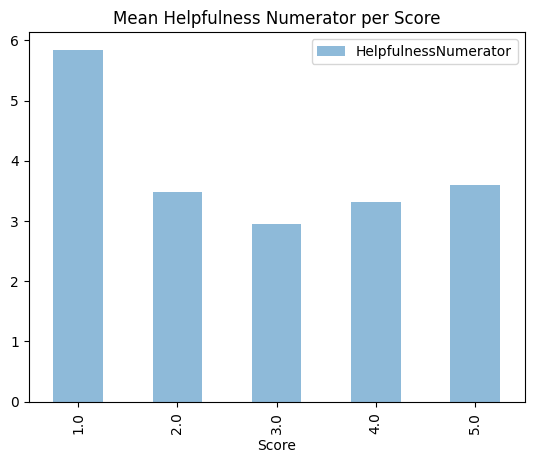

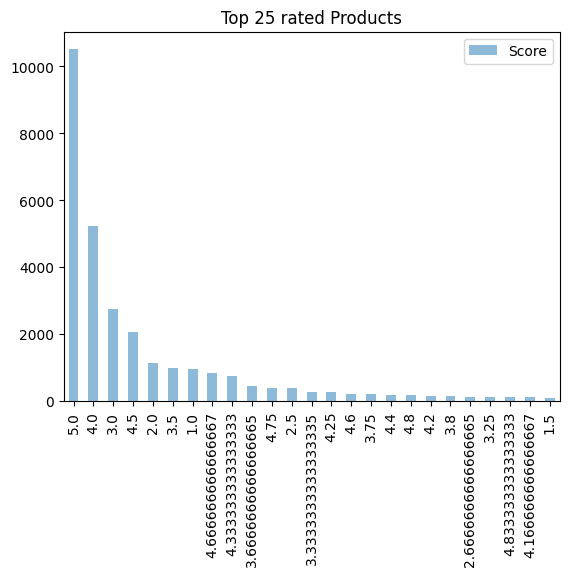

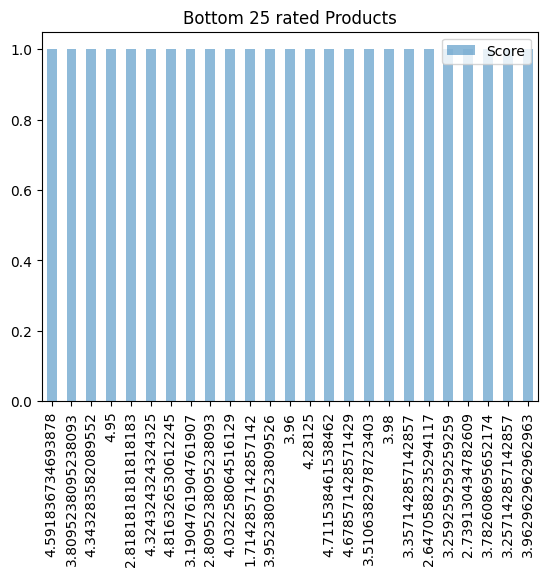

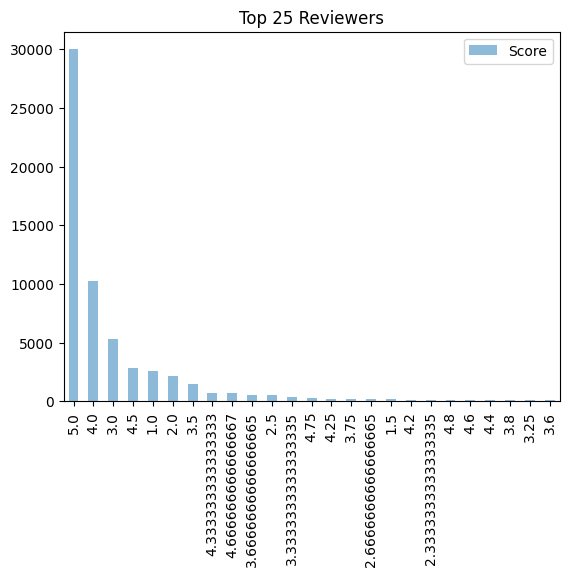

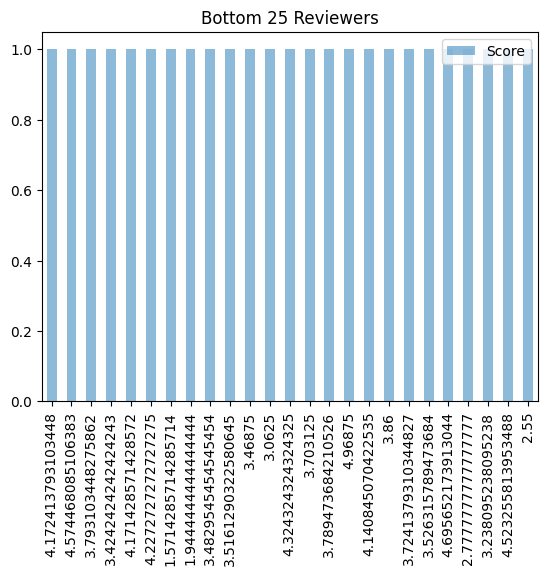

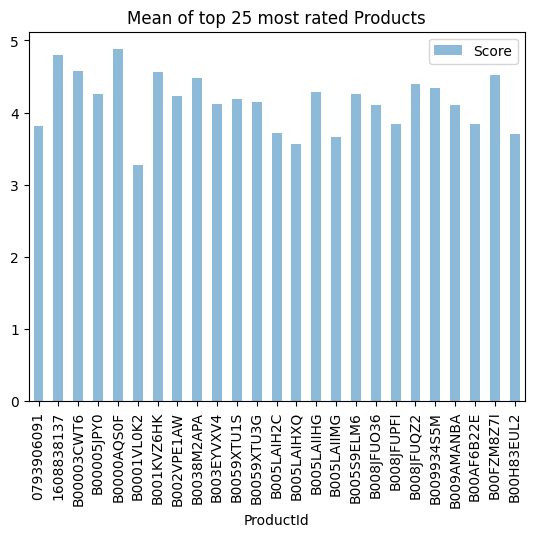


Correlation matrix:
                              Id  HelpfulnessNumerator  \
Id                      1.000000             -0.016895   
HelpfulnessNumerator   -0.016895              1.000000   
HelpfulnessDenominator -0.021171              0.958361   
Time                    0.453115             -0.128377   
Score                  -0.050072             -0.013004   

                        HelpfulnessDenominator      Time     Score  
Id                                   -0.021171  0.453115 -0.050072  
HelpfulnessNumerator                  0.958361 -0.128377 -0.013004  
HelpfulnessDenominator                1.000000 -0.155257 -0.095208  
Time                                 -0.155257  1.000000  0.089082  
Score                                -0.095208  0.089082  1.000000  

Correlation matrix:
                              Id  HelpfulnessNumerator  \
Id                      1.000000             -0.016895   
HelpfulnessNumerator   -0.016895              1.000000   
HelpfulnessDenominato

/var/folders/_0/62j9c1s53kb6h59h2bd0mtx40000gn/T/ipykernel_35227/2462831412.py:68: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(trainingSet.corr())
/var/folders/_0/62j9c1s53kb6h59h2bd0mtx40000gn/T/ipykernel_35227/2462831412.py:71: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = trainingSet.corr()


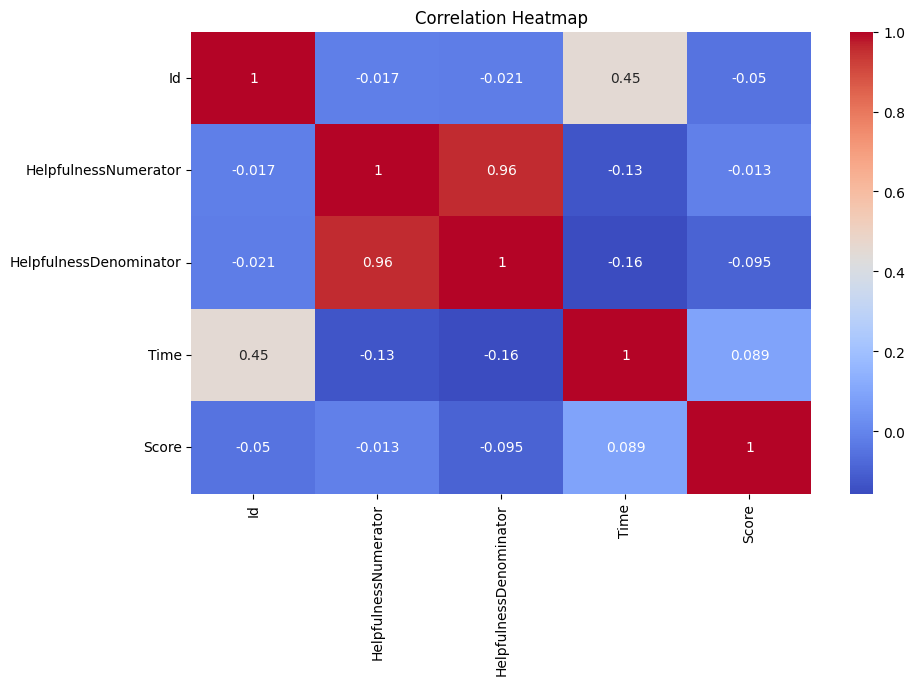

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Read data
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

# Print dataset shapes
print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

# Check for missing values
print("\nMissing values in training set:\n", trainingSet.isna().sum())

# Display the first few rows of each dataset
print("\nTraining set head:")
print(trainingSet.head())
print("\nTesting set head:")
print(testingSet.head())

# Display summary statistics
print("\nSummary statistics for training set:")
print(trainingSet.describe())

# Plot the distribution of scores
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

# Set the number of products and reviewers to display
n_display = 25

def plot_largest_smallest(df, title_prefix, n):
    df.value_counts().nlargest(n).plot(kind='bar', legend=True, alpha=.5)
    plt.title(f"Top {n} {title_prefix}")
    plt.show()

    df.value_counts().nsmallest(n).plot(kind='bar', legend=True, alpha=.5)
    plt.title(f"Bottom {n} {title_prefix}")
    plt.show()


# Plot most and least rated products
plot_largest_smallest(trainingSet['ProductId'], "rated Products", n_display)

# Plot top and bottom reviewers
plot_largest_smallest(trainingSet['UserId'], "Reviewers", n_display)


# Plot mean Helpfulness Numerator per Score
trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")
plt.show()

# Plot best and worst rated products
plot_largest_smallest(trainingSet[['Score', 'ProductId']].groupby('ProductId').mean()['Score'], "rated Products", n_display)

# Plot kindest and harshest reviewers
plot_largest_smallest(trainingSet[['Score', 'UserId']].groupby('UserId').mean()['Score'], "Reviewers", n_display)

# Plot the mean score of the top 25 most rated products
trainingSet[trainingSet['ProductId'].isin(trainingSet['ProductId'].value_counts().nlargest(n_display).index.tolist())][['Score', 'ProductId']].groupby('ProductId').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title(f"Mean of top {n_display} most rated Products")
plt.show()

# Investigate the correlation between features
print("\nCorrelation matrix:")
print(trainingSet.corr())

# Calculate the correlation matrix
correlation_matrix = trainingSet.corr()

# Print the correlation matrix
print("\nCorrelation matrix:")
print(correlation_matrix)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



## Feature Extraction

In [78]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

def process(df):
    # Calculate helpfulness
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Calculate review length
    df['ReviewLength'] = df.apply(lambda row: len(row['Text'].split()) if type(row['Text']) == str else 0, axis=1)

    # Calculate summary length
    df['SummaryLength'] = df.apply(lambda row: len(row['Summary'].split()) if type(row['Summary']) == str else 0, axis=1)

    # Extract review year from timestamp
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year

    # Create a binary feature for positive reviews
    df['PositiveReview'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)
    
    # Sentiment analysis using TextBlob
    df['ReviewSentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity if type(x) == str else 0)
    df['SummarySentiment'] = df['Summary'].apply(lambda x: TextBlob(x).sentiment.polarity if type(x) == str else 0)

    # Create TF-IDF features for Text and Summary
    text_tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    summary_tfidf = TfidfVectorizer(max_features=50, stop_words='english')

    text_features = text_tfidf.fit_transform(df['Text'].values.astype('U')).toarray()
    summary_features = summary_tfidf.fit_transform(df['Summary'].values.astype('U')).toarray()

    text_df = pd.DataFrame(text_features, columns=["text_tfidf_" + str(i) for i in range(text_features.shape[1])])
    summary_df = pd.DataFrame(summary_features, columns=["summary_tfidf_" + str(i) for i in range(summary_features.shape[1])])

    df = pd.concat([df, text_df, summary_df], axis=1)

    return df

# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

# Process the DataFrame
train_processed = process(trainingSet)

# Load test set
submissionSet = pd.read_csv("./data/test.csv")
 
# Merge on Id so that the test set can have feature columns as well
testX = pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX = train_processed[train_processed['Score'].notnull()]

# Save the datasets with the new features for easy access later
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

## Creating your model

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunzheyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy on testing set =  0.6176816664016537
RMSE on testing set =  0.28075498265191007


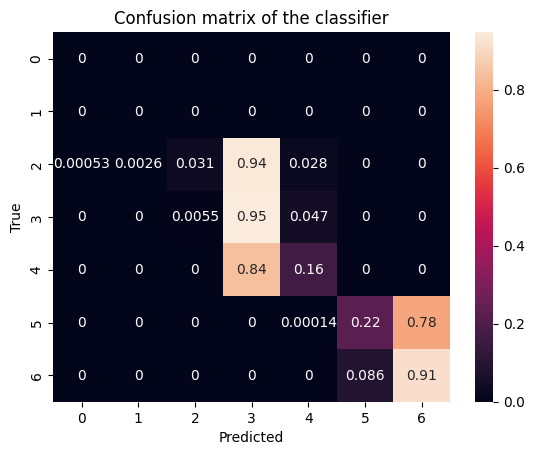

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")

# Text preprocessing
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    tokens = word_tokenize(text)
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return " ".join(stemmed_tokens)

X_train['Text'] = X_train['Text'].apply(preprocess_text)




# Create TF-IDF features for Text
text_tfidf = TfidfVectorizer(max_features=100, stop_words='english')
text_features = text_tfidf.fit_transform(X_train['Text']).toarray()
text_df = pd.DataFrame(text_features, columns=["text_tfidf_" + str(i) for i in range(text_features.shape[1])])
X_train = pd.concat([X_train, text_df], axis=1)

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(['Score'], axis=1),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# This is where you can do more feature selection
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])

# Initialize the LinearRegression model
lr = LinearRegression()

# Fit the model
lr.fit(X_train_processed, Y_train)

# Make predictions
Y_test_predictions = lr.predict(X_test_processed)
Y_test_rounded_predictions = np.round(Y_test_predictions)
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_rounded_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))



# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_rounded_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Create the Kaggle submission

In [83]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

X_submission['Score'] = lr.predict(X_submission_processed)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


Now you can upload the `submission.csv` to kaggle